In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset, make_train_test_val_split
from plotting import show_img, loss_plots, plot_random_images, plot_image_comparison, plot_latent
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [2]:
val = True
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])
dataset = OwnDataset(transform=tf, path=r"C:\Users\Otto\Desktop\Fagprojekt_data\labelled_data")
# dataset = OwnDataset(transform=tf)
train_subset, test_subset, val_subset = make_train_test_val_split(dataset)




train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, pin_memory=cuda)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=True, pin_memory=cuda)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=True, pin_memory=cuda)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))

488396 4884 1527 1221


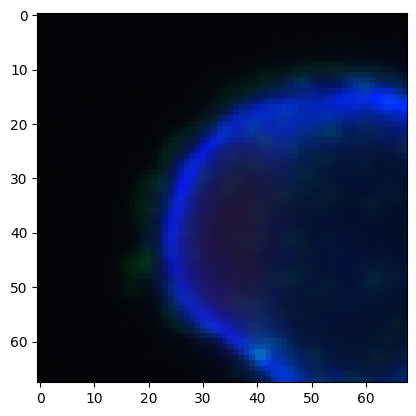

'Actin disruptors'

In [3]:
# get a sample image from the dataset
sample = dataset[612][0]
label = dataset[612][1]

# show the image
show_img(sample.view(3,68,68))

# moa
# data_train.dataset.class_to_idx
dataset.dataset.classes[label]


# Latent classifier

In [4]:
from models import LatentClassifier, VAE_LAFARGE, VAE_CELL_CNN, VAE_CELL_linear
from loss_functions import loss_function

vae = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=512, latent_dim=256)
latent_classifier = LatentClassifier(latent_dim=256, hidden_dim=128, num_classes=len(dataset.dataset.classes))
print(vae)
print(latent_classifier)

if cuda:
    vae = vae.cuda()
    latent_classifier = latent_classifier.cuda()

optimizer = optim.Adam(vae.parameters(), lr=0.001)
latent_optimizer = optim.Adam(latent_classifier.parameters(), lr=0.001)
latent_loss_fn = nn.CrossEntropyLoss()


VAE_CELL_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=20736, out_features=512, bias=True)
  )
  (mu): Linear(in_features=512, out_features=256, bias=True)
  (logvar): Linear(in_features=512, out_features=256, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=20736, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Unflatten(dim=1, unflat

In [5]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = vae(x)
x_hat = output["x_hat"]
z = output["z"]
print(f"x_hat.shape: {x_hat.shape}")
assert x_hat.shape == x.shape

# test latent model
output_latent = latent_classifier(z)
print(f"output_latent.shape: {output_latent.shape}")

# output.shape

x.shape: torch.Size([64, 3, 68, 68])
x_hat.shape: torch.Size([64, 3, 68, 68])
output_latent.shape: torch.Size([64, 13])


In [6]:
# torch.autograd.set_detect_anomaly(True)

num_epochs = 10

train_loss = []
train_mse_loss = []
train_kld_loss = []
latent_train_loss = []
latent_train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(num_epochs):
    batch_loss = []
    mse_batch_loss = []
    kld_batch_loss = []
    latent_batch_loss = []
    latent_batch_accuracy = []
    vae.train()
    latent_classifier.train()

    for x, y in train_loader:
        if cuda:
            x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        latent_optimizer.zero_grad()
        
        output = vae(x)

        # vae model
        x_hat, mu, sigma = output["x_hat"], output["mu"], output["sigma"]
        loss_fn = loss_function(x, x_hat, mu, sigma)
        mse_loss = loss_fn["MSE"]
        kld_loss = loss_fn["KLD"]
        loss = loss_fn["loss"]
        loss.backward()
        optimizer.step()

        # vae losses
        batch_loss.append(loss.item())
        mse_batch_loss.append(mse_loss.item())
        kld_batch_loss.append(kld_loss.item())

        # latent model
        z = output["z"]
        z = z.detach()
        output_latent = latent_classifier(z)
        latent_loss = latent_loss_fn(output_latent, y)
        latent_loss.backward()
        latent_optimizer.step()

        # latent losses
        pred = output_latent.argmax(dim=1)
        acc = accuracy_score(y.cpu().numpy(), pred.cpu().numpy())
        latent_batch_accuracy.append(acc)
        latent_batch_loss.append(latent_loss.item())


    
    train_loss.append(np.mean(batch_loss))
    train_mse_loss.append(np.mean(mse_batch_loss))
    train_kld_loss.append(np.mean(kld_batch_loss))
    latent_train_loss.append(np.mean(latent_batch_loss))
    latent_train_accuracy.append(np.mean(latent_batch_accuracy))

    if val:
        vae.eval()
        latent_classifier.eval()
        val_batch_loss = []
        val_batch_accuracy = []
        for x, y in val_loader:
            if cuda:
                x, y = x.cuda(), y.cuda()

            output = vae(x)
            x_hat, mu, sigma = output["x_hat"], output["mu"], output["sigma"]
            loss_fn = loss_function(x, x_hat, mu, sigma)
            mse_loss = loss_fn["MSE"]
            kld_loss = loss_fn["KLD"]
            loss = loss_fn["loss"]
            val_batch_loss.append(loss.item())

            z = output["z"]
            z = z.detach()
            output_latent = latent_classifier(z)
            pred = output_latent.argmax(dim=1)
            acc = accuracy_score(y.cpu().numpy(), pred.cpu().numpy())
            val_batch_accuracy.append(acc)

        val_loss.append(np.mean(val_batch_loss))
        val_accuracy.append(np.mean(val_batch_accuracy))

        

    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}")
    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse: {train_mse_loss[-1]}, kld: {train_kld_loss[-1]}")
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse: {train_mse_loss[-1]}, kld: {train_kld_loss[-1]}, latent_loss: {latent_train_loss[-1]}, latent_acc: {latent_train_accuracy[-1]}")



Epoch 1/10, loss: 7913.65680896406, mse: 6077.051835293657, kld: 1836.6049763933984, latent_loss: 1.1871562900355759, latent_acc: 0.6531235070297571
Epoch 2/10, loss: 6271.306499759258, mse: 4253.171803317433, kld: 2018.134697841485, latent_loss: 1.0683811123526359, latent_acc: 0.6809223996723996
Epoch 3/10, loss: 6098.24373622335, mse: 4038.49355246804, kld: 2059.7501847800613, latent_loss: 1.045695701282987, latent_acc: 0.6862041018291019
Epoch 4/10, loss: 6004.841305794431, mse: 3922.270794992658, kld: 2082.570509752028, latent_loss: 1.0325267314666808, latent_acc: 0.689181511056511
Epoch 5/10, loss: 5945.594089317478, mse: 3849.247957746676, kld: 2096.3461324455893, latent_loss: 1.0209971184885764, latent_acc: 0.6916589885339886
Epoch 6/10, loss: 5900.510873055673, mse: 3795.1487944631867, kld: 2105.36208186669, latent_loss: 1.0125230487548944, latent_acc: 0.692586123054873


In [ ]:
def train_model(model, latent_classifier, train_loader, val_loader, optimizer, latent_optimizer, loss_fn, latent_loss_fn, num_epochs=10, cuda=False):
    train_loss = []
    train_mse_loss = []
    train_kld_loss = []
    latent_train_loss = []
    latent_train_accuracy = []
    val_loss = []
    val_accuracy = []

    for epoch in range(num_epochs):
        batch_loss = []
        mse_batch_loss = []
        kld_batch_loss = []
        latent_batch_loss = []
        latent_batch_accuracy = []
        model.train()
        latent_classifier.train()

        for x, y in train_loader:
            if cuda:
                x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            latent_optimizer.zero_grad()
            
            output = model(x)

            # vae model
            x_hat, mu, sigma = output["x_hat"], output["mu"], output["sigma"]
            loss_fn = loss_function(x, x_hat, mu, sigma)
            mse_loss = loss_fn["MSE"]
            kld_loss = loss_fn["KLD"]
            loss = loss_fn["loss"]
            loss.backward()
            optimizer.step()

            # vae losses
            batch_loss.append(loss.item())
            mse_batch_loss.append(mse_loss.item())
            kld_batch_loss.append(kld_loss.item())

            # latent model
            z = output["z"]
            z = z.detach()
            output_latent = latent_classifier(z)
            latent_loss = latent_loss_fn(output_latent, y)
            latent_loss.backward()
            latent_optimizer.step()

            # latent losses
            pred = output_latent.argmax(dim=1)
            acc = accuracy_score(y.cpu().numpy(), pred.cpu().numpy())
            latent_batch_accuracy.append(acc)
            latent_batch_loss.append(latent_loss.item())


        
        train_loss.append(np.mean(batch_loss))
        train_mse_loss.append(np.mean(mse_batch_loss))
        train_kld_loss.append(np.mean(kld_batch_loss))
        latent_train_loss.append(np.mean(latent_batch_loss))
        latent_train_accuracy.append(np.mean(latent_batch_accuracy))

        if val:
            model.eval()
            latent_classifier.eval()
            val_batch_loss = []
            val_batch_accuracy = []
            for x, y in val_loader:
                if cuda:
                    x, y = x.cuda(), y.cuda()

                output = model(x)
                x_hat, mu, sigma = output["x_hat"], output["mu"], output["sigma"]
                loss_fn = loss_function(x, x_hat, mu, sigma)
                mse_loss = loss_fn["MSE"]
                kld_loss = loss_fn["KLD"]
                loss = loss_fn["loss"]
                val_batch_loss.append(loss.item())

                z = output["z"]
                z = z.detach()
                output_latent = latent_classifier(z)
                pred = output_latent.argmax(dim=1)
                acc = accuracy_score(y.cpu().numpy(), pred.cpu().numpy())
                val_batch_accuracy.append(acc)
                
            val_loss.append(np.mean(val_batch_loss))
            val_accuracy.append(np.mean(val_batch_accuracy))


        print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse: {train_mse_loss[-1]}, kld: {train_kld_loss[-1]}, latent_loss: {latent_train_loss[-1]}, latent_acc: {latent_train_accuracy[-1]}")

    return train_loss, train_mse_loss, train_kld_loss, latent_train_loss, latent_train_accuracy, val_loss, val_accuracy

# train the model
vae = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=512, latent_dim=256)
latent_classifier = LatentClassifier(latent_dim=256, hidden_dim=128, num_classes=len(dataset.dataset.classes))

if cuda:
    vae = vae.cuda()
    latent_classifier = latent_classifier.cuda()

optimizer = optim.Adam(vae.parameters(), lr=0.001)
latent_optimizer = optim.Adam(latent_classifier.parameters(), lr=0.001)
latent_loss_fn = nn.CrossEntropyLoss()

train_loss, train_mse_loss, train_kld_loss, latent_train_loss, latent_train_accuracy, val_loss, val_accuracy = train_model(vae, latent_classifier, train_loader, val_loader, optimizer, latent_optimizer, loss_function, nn.CrossEntropyLoss(), num_epochs=10, cuda=cuda)
